**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1qrLnil5zRwIt3QuPaTAYQ_TDOqUP6T6x?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1B1tj5Xd3jDnVtAtz4UzJwQZeIgS-srsV?usp=sharing)

3. Практический ноутбук 2

В данном ноутбуке мы построим систему распознавания голосовых команд умного дома. Распознавать будем 3 команды:

1.   Свет
2.   Кондиционер
3.   Телевизор

Из теоретической части занятия мы знаем, что распознавание голосовых команд это задача классификации фрагментов аудиосигнала. Поэтому нам обязательно нужна база этих команд, её мы подгрузим кодом ниже.

Ещё нам понадобятся библиотеки для работы с аудио, такие как librosa и IPython. 
Наша задача:
*построить такую систему, которой на вход будем подавать аудиозапись, а на выходе получать одну из распознанных команд.*

Первым делом нам нужно обучить нейронную сеть классификации аудиосигнала. У нас будет 4 класса: 1 - кондиционер, 2 - свет, 3 - телевизор, 4 - шум (фон). В класс шум будем подавать записи любых других слов, не относящихся к нашим трем командам.



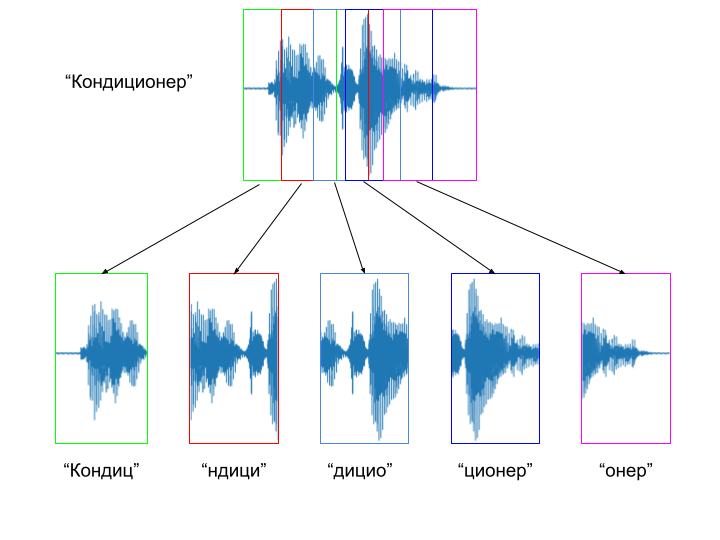

Для расширения выборки и увеличения точности распознавания, аудиозапись каждой фразы каждого из четырех классов будет раскусана на более мелкие кусочки с небольшим шагом. Например, секундная аудиозапись фразы "Кондиционер" будет раскусана на 5 отрезков по 0.3 секунды каждый с определенным шагом. Мы получим не только больше примеров для каждого класса, но и большую вариативность распознавания. Если, при произношении команды, какие-то буквы будут плохо распознанны и первая часть слова не идентифицируется как команда, но вторая часть слова будет распознана хорошо, то сеть классифицирует команду правильно.

## Загрузка библиотек и данных

In [ ]:
# Библиотека для работы с массивами данных
import numpy as np 

# Интерфейс для построения графиков простых функций
from matplotlib import pyplot as plt 

# Загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from IPython.display import Audio 

# Библиотека для параметризации аудио
import librosa 

# Модуль для работы с каталогами 
import os 

# Модуль для разбивки данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split 

# Загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import to_categorical 

# Быстрый и удобный progress bar для Python
from tqdm import tqdm 

# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta 

# Последовательная модель нейросети кераса
from tensorflow.keras.models import Sequential 

# Загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape 

# Библиотека для воспроизведения звуковых файлов
import IPython.display as ipd

# Загрузка датасетов из облака google
import gdown

In [ ]:
# Данные для обучения
url = 'https://storage.yandexcloud.net/aiueducation/Content/advanced/l15/data.zip'
gdown.download(url, None, quiet=False)

# Данные для теста
url = 'https://storage.yandexcloud.net/aiueducation/Content/advanced/l15/test.zip'
gdown.download(url, None, quiet=False)

Downloading...
From: https://storage.googleapis.com/datasets_ai/Advanced/15_audio/data.zip
To: /content/data.zip
100%|██████████| 130M/130M [00:01<00:00, 81.9MB/s]
Downloading...
From: https://storage.googleapis.com/datasets_ai/Advanced/15_audio/test.zip
To: /content/test.zip
100%|██████████| 107M/107M [00:00<00:00, 117MB/s]


'test.zip'

In [ ]:
# Разархивируем обучающие данные
!unzip -q '/content/data.zip' -d /content/data

# Разархивируем тестовые данные
!unzip -q '/content/test.zip' -d /content/test

In [ ]:
# Зададим путь к папке с аудиофайлами
DATA_PATH = "/content/data/" 

# Зададим пусть к файлу с тестовыми 30-тисекнудными аудиофайлами
DATA_PATH_TEST = "/content/test/"

## Объявление функций



Зададим параметры данных, которые пойдут на вход нейросети:

In [ ]:
sample_rate = 22050                   # Значение sample_rate аудиофайлов
feature_dim_1 = 20                    # Стандартная величина MFCC признаков
feature_dim_2 = int(.5 * sample_rate) # Длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate)    # Шаг смещения (в секундах 0.1 = 100мс)
channel = 1                           # Количество каналов
n_classes = 4                         # Количество классов команд (4-ый класс - шум)

classes = ['КОНДИЦИОНЕР',             # Классы команд (без шума)
           'СВЕТ',
           'ТЕЛЕВИЗОР'] 

In [ ]:
def get_labels(path=DATA_PATH): 
  
  '''
  Функция извлечения лейблов классов и их обработки

  Args:
    path - путь к папке, в которой находятся каталоги с обучающими командами 

  Returns:
    labels - имена лейблов, str
    label_indices - индексы лейблов, int
    to_categorical(label_indices) - ohe лейблов
  '''
  
  # Запишем лейблы классов по названию папок - ['кондиционер', 'телевизор', 'свет', 'фон']  
  labels = sorted(os.listdir(path)) 
  
  # Запишем лейблы в виде индексов - [0, 1, 2, 3]
  label_indices = np.arange(0, len(labels)) 
  
  # Функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0]
  return labels, label_indices, to_categorical(label_indices) 

In [ ]:
# Выведем имена лейблов
l,_,_ = get_labels()
l

['1_cond', '2_light', '3_tv', '4_noise']

Следующая функция `wav2mfcc` преобразует аудиозапись в `mfcc`. Если на классификацию подавать просто сигнал (последовательность отчетов), то классификация работает плохо, поэтому мы будем подавать `mfcc`.

Можно попробовать преобразовать сигнал и во что-нибудь другое, например спектральный центроид, или `stft` и делать классификацию по таким данным.

На вход этой функции приходит аудиозапись, мы её разрезаем на кусочки длины `length` с шагом `step`, преобразуем их в `mfcc` и сохраняем в список.

Значения `length` и `step` не в секундах, а в отчетах. Каждая секунда записи содержит 22050 отчетов, следовательно `length` = 11025 это пол секунды, а `step` = 2205 это десятая часть секунды.

In [ ]:
def wav2mfcc(file_path, 
             length = 11025, 
             step = 2205): 
  '''
  Функция параметризации аудио(wav в мел-частоты)

  Args:
    file_path - путь к аудио файлу
    length - длинна отрезков, на которые разбиваем исходный файл, int
    step - шаг, на который смещаем разбиение отрезка, int

  Returns:
    out_mfcc - массив мел-частот
    out_audio - массив аудио-отрезков
  '''
  
  # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_mfcc = []  

  # Выходной массив, содержащий аудиоинформацию исходного файла с шагом step
  out_audio = []                  
  
  # Загружаем данные исходного файла
  y, sr = librosa.load(file_path)   

  # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
  while (len(y)>=length):                              
    
    # Берем начальный кусок длинной length
    section = y[:length]
    # Переводим в numpy
    section = np.array(section) 
    # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_mfcc.append(librosa.feature.mfcc(section, sr))
    # Добавляем в выходной массив аудио текущий кусок
    out_audio.append(section)      
    # Уменьшаем y на step
    y = y[step:]                                       
    
  # Преобразуем в numpy
  out_mfcc = np.array(out_mfcc)    
  
  # Преобразуем в numpy
  out_audio = np.array(out_audio)  
  
  # Функция вернет массив мел-частот и массив аудио-отрезков
  return out_mfcc, out_audio       

Следущая функция `save_data_to_array` позволяет пройти по всем аудиозаписям и применить к ним предыдущую функцию `wav2mfcc`. После этого все данные сохраняются в директории в виде массива numpy (отдельный файл для каждого класса).

In [ ]:
def save_data_to_array(path=DATA_PATH, 
                       length=11025):
  '''
  Функция формирования и сохранения векторов данных, 
  полученных для каждого набора аудио-команд в датасете

  Args:
    path - путь к папке, в которой находятся каталоги с обучающими командами    
    length - длинна отрезков, на которые разбиваем исходный файл

  Returns:
    
  '''

  # Извлекаем лейблы классов
  labels, _, _ = get_labels(path) 
  
  # Проходим циклом по каждому лейблу
  for label in labels:            
    
    # Собираем векторы MFCC частот
    mfcc_vectors = []            
    # Извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

    # Для каждого файла
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): 
      # Получим мел-частоты
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc)       
      
      # Если массив не нулевой длинны
      if (mfcc.shape[0] != 0 ):           
        # Добавим вектор в список для соответствующего класса
        mfcc_vectors.extend(mfcc)         
    
    # Сохраним массивы данных для каждого класса
    np.save(label + '.npy', mfcc_vectors) 

Функция `get_train_test()` разделяет данные на обучающую и проверочную выборки.

In [ ]:
def get_train_test(split_ratio=0.7, 
                   random_state=42, 
                   colab = True):
  '''
  Функция для получения обучающей/проверочной выборки

  Args:
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split, float [0..1]
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split, int
    colab - запускаем код в колабе или нет, bool

  Returns:
    4 массива обучающих и проверочных данных
  '''

  labels, indices, _ = get_labels(DATA_PATH)  # Извлекаем имена и индексы лейблов классов
  X = np.load('/content/'+labels[0] + '.npy') # Берем набор векторов для первого класса 
  y = np.zeros(X.shape[0], dtype = 'int32')   # Устанавливаем размер соответствующего ему лейбла

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]): 
    
    # Условие, если запускаем а колабе
    if colab:                                 
      # Читаем очередной массив данных
      x = np.load(label + '.npy')              
    else:                                     
      # Читаем очередной массив данных
      x = np.load('/content/'+label + '.npy')  
    
    # Соединяем с исходным набором
    X = np.vstack((X, x))                     
    
    # В массив y добавлем x.shape[0]-элеменентов со значением (i + 1)
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1))) 
  
  # Разделяем данные на обучающую и проверочную выборки
  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 

## Подготовка данных



Теперь, на основе созданных функций подготовим данные для обучения НС.

In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
# ВНИМАНИЕ! Ячейка будет обрабатывать файлы около 8 минут

save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - '4_noise': 100%|██████████| 50/50 [08:48<00:00, 10.58s/it]


In [ ]:
# Формируем обучающую и проверочную выборки

x_train, x_test, y_train, y_test = get_train_test(colab=False)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(56355, 20, 22) (56355,)
(24153, 20, 22) (24153,)


In [ ]:
# Добавляем ещё одну размерность в конце 'x' выборок, для использования сверток

x_train = x_train[..., None]
x_test = x_test[..., None]

# Представляем лейблы классов обучающего и проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)

y_train_hot = to_categorical(y_train) 
y_test_hot = to_categorical(y_test)   

In [ ]:
# Выведем размерность x_train
x_train.shape

(56355, 20, 22, 1)

In [ ]:
# Посмотрим сколько примеров имеет класс шум

idx = np.where(y_train==3)
idx[0].shape

(50787,)

## Нейросеть



In [ ]:
# Объявим функцию создания модели нейросети

def get_model():

  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Flatten())                      # Сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu'))  # Добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # Добавляем полносвязный слой с функцией активации softmax на выходном слое для 4 классов
  
  # Компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])       
  
  return model

In [ ]:
# Создаем модель с помощью объявленной ранее функции

model = get_model() 

Запустим тренировку нейросети на полученных данных

Epoch 1/20
221/221 [==============================] - 10s 40ms/step - loss: 0.3162 - accuracy: 0.8996 - val_loss: 0.0386 - val_accuracy: 0.9910
Epoch 2/20
221/221 [==============================] - 9s 39ms/step - loss: 0.0338 - accuracy: 0.9912 - val_loss: 0.0215 - val_accuracy: 0.9949
Epoch 3/20
221/221 [==============================] - 8s 38ms/step - loss: 0.0204 - accuracy: 0.9943 - val_loss: 0.0170 - val_accuracy: 0.9949
Epoch 4/20
221/221 [==============================] - 9s 38ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0130 - val_accuracy: 0.9956
Epoch 5/20
221/221 [==============================] - 8s 38ms/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.0067 - val_accuracy: 0.9983
Epoch 6/20
221/221 [==============================] - 9s 39ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0094 - val_accuracy: 0.9971
Epoch 7/20
221/221 [==============================] - 9s 39ms/step - loss: 0.0089 - accuracy: 0.9966 - val_loss: 0.0058 - val_accuracy: 0.998

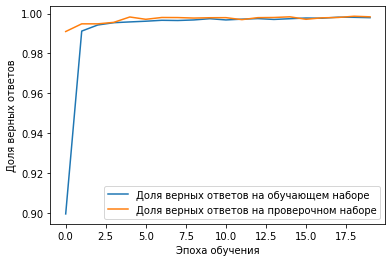

In [ ]:
# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика

history = model.fit(x_train, 
                    y_train_hot, 
                    batch_size=256, 
                    epochs=20, 
                    verbose=1, 
                    validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Проверка


Для проверки мы будем использовать аудиофайлы, в которых наговаривается текст из книги и иногда произносится одна из трех фраз "Кондиционер", "Свет", "Телевизор".

In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + 'text_with_cond3.wav' 

# Загружаем данные модулем librosa
y,sr = librosa.load(wavfiles)                      

# Выводим оригинальный аудиофайл (Команда "Кондиционер" начинается на 12 секунде)
print('Оригинальный файл:')
ipd.Audio(data=y, rate = sr) 

Оригинальный файл:


In [ ]:
# Получаем массив mfcc выбранного файла с именем namefile 
mfcc_full, audio_full = wav2mfcc(wavfiles, length=feature_dim_2, step = step_mfcc) 

# Решейпим для сверточного слоя
mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)    

# Предиктим с помощью модели model массив mfcc
g_pred = model.predict(mfcc_full)    

# Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов
pred = np.array([np.argmax(i) for i in g_pred]) 

In [ ]:
print(g_pred.shape)

print(pred.shape)

print(pred[:1000])

(1426, 4)
(1426,)
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 3 3 3 3 3 3 3 3 3 0
 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 

На выходе мы получаем массив, состоящий только из значений 0, 1, 2 или 3. Каждое число это класс отрезка длиной length (в нашем случае это пол секунды). Шаг между отрезками 0.1 секунды, поэтому из записи, длиной 29 секунд мы получили 1425 отрезков.

Обратите внимание, что в массиве больше всего значений 3 - это класс "Шум", что логично, т.к. в этой аудиозаписи из всего текста (из всех слов) только одна голосовая команда из нашего набора "Кондиционер", на 12-ой секунде.

Ещё есть варианты 1 и 0, значения 2 нету совсем. Значение 0 это наш класс "Кондиционер", который произносится на 12 секунде, но иногда нейронная сеть распознает его среди фрагментов и в других местах.  

В идеале, нейронная сеть из этой аудиозаписи должна получить везде значения 3 и только в одном месте последовательность из 0 (примерно 20-30 штук), но даже хорошая нейронная сеть может изредка ошибаться.

Поэтому, нужна постобработка (окончательная обработка) результата. Постобработка будет заключаться в очищении полученных результатов от шумов и ошибок. Давайте выведем индексы всех значений класса 0.

In [ ]:
# В массиве pred находим все элементы со значением, равным искомому классу idx_class
idxs = np.where(pred == 0) 

# Размерность полученного масива в np.where имеет тип (x,). Оставляем только первую размерность
idxs = idxs[0] 
print(idxs)

[ 25  26  36  37  38  39  40 234 458 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 957 958 959 960]


С большой вероятностью, значения, которые являются обособленными (соседние значения другого класса) можно считать как неправильно распознанные, следовательно они нас не интересуют и их можно игнорировать. Поэтому, для исключения обособленных (одинарных) распознанных значений и других коротких последовательностей, зададим параметр `min_count`. Сделаем так, чтобы все последовательности, длина которых меньше этого параметра, игнорировались.

Значение `min_count` задается приблизительно, на усмотрение разработчика и исходя из длины распознаваемого слова, например для слова "кондиционер" значение `min_count` должно быть больше, чем для слова "свет", т.к. первое слово произносится дольше.



In [ ]:
# Минимальная длина последовательности одного класса

min_count = 8           

Зададим порог среднего значения вероятности `rate`. Будем брать только те последовательности, у которых среднее значение вероятности больше установленного значения `rate`.



In [ ]:
# Порог среднего значения вероятности

rate = 0.95             

Создадим список `curr`, в который будем в виде списка добавлять стартовый индекс найденной команды (`curr_idx`), длину последовательности (`length`) и `summ / length`, если условия по `min_count` и `rate`  выполняются:

In [ ]:
# Временный массив для хранения информации о найденных командах

curr = []               


Зададим текущий стартовый индекс `curr_idx`, установим `length` - длину последовательно идущих элементов для одной команды (изначально 0) и `summ` - хранит сумму вероятностей `g_pred[idxs[i]][0]`, с которой сеть отнесла команду к данному классу (изначально 0):

In [ ]:
# Текущий стартовый индекс
curr_idx = int(idxs[0])  

# summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; 
summ = 0 

# length - длина последовательно идущих элементов для одной команды
length = 0   

Пробегаем по всему массиву `idxs`, считаем сумму вероятностей `summ` и увеличиваем длину последовательности `lenght`.

Сначала установим правило для последнего элемента последовательности - если длина последовательности больше двух и `summ / length` больше входного параметра `rate,` пополняем список `curr` и прерываем выполнение цикла.

Если это не последний элемент списка, то проверяем, является ли значение элемента больше предыдущего на единицу (тогда они принадлежат разным командам).
 1. Если да, проверяем больше ли длина последовательности, чем ее минимальное значение `min_count`, больше ли `summ / length` порогового значения `rate` и если да, то пополняем список `curr`
 2. Если нет, то изменяем текущий стартовый индекс и обнуляем переменные `summ` и `length`.

В конце выводим на печать содержание списка `curr`.


In [ ]:
for i in range(len(idxs)):   # Пробегаем по всему массиву idxs

  # Считаем сумму вероятности
  summ += g_pred[idxs[i]][0] 
  # Увеличиваем длину последовательности
  length += 1                
  
  # Если последний элемент последовательности
  if i == len(idxs)-1:       
    
    # Проверяем условия
    if (length >= 2 and summ / length >= rate): 
      # Если условия выполняются
      curr.append([curr_idx, length, summ / length]) 
    break                                            
  
  # Если элемент относится к другой команде
  if idxs[i+1]-idxs[i]>1:  
    
    # Проверяем условия
    if (length >= min_count and summ / length >= rate): 
      # Если условия выполняются
      curr.append([curr_idx, length, summ / length])
    
    # Изменяем текущий стартовый индекс
    curr_idx = int (idxs[i+1]) 
    # Обнуляем summ и length
    summ, length = 0, 0        

# Выведем на экран результат
print(curr)                    

[[648, 28, 0.9763622156211308]]


В итоге мы получили только одну последовательность, которая удовлетворяет всем условиям (длина последовательности больше 8, среднее значение вероятности больше 0.95).
    
    650  - индекс первого отрезка распознанного класса
    26   - количество отрезков этого класса в последовательности
    0.98 - среднее значение вероятности всех отрезков (эти значения получены из предикта НС)

Теперь мы можем объединить все отрезки последовательности в общий аудиофайл. Для этого создадим 2 пустых списка `np_Audio` и `curr_audio`. Список `np_Audio` будет содержать все распознанные команды в аудиозаписи (если их несколько, в нашем случае только одна такая последовательность), а в  `curr_audio` будем записывать отдельные команды на каждой итерации (в нашем случае будет только одна итерация).

In [ ]:
np_Audio = []     # Список для полного mfcc 
curr_audio = []   # mfcc отдельной команды

Дальше нужно пройти циклом по каждой распознанной команде (в нашем случае одна распознанная команда) и соединить все кусочки в один аудио файл, чтобы получить распознанную команду полностью, а не её часть.

Если индексы нашей распознанной команды, например, такие: 

    131, 132, 133, 134, 135, 136, 137
то соединять мы будет с 130 отрезка по 137 включительно, т.к там может быть начало команды, которое было не распознано или тишина.

In [ ]:
# Проходим по всему массиву curr
for elem in curr: 

  # Записываем в переменную первый элемент распознанной команды
  curr_audio = audio_full[elem[0]] 
  
  # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее
  if (elem[0] != 0): 
    curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))        
  
  # Пробегаем циклом от 1 до elem[1] (где elem[1] - количество отрезков этого класса в последовательности)
  for j in range(1,elem[1]): 
    
    # Если elem[0] + j равно длинне mfcc, то выходим из цикла
    if (elem[0]+j == len(audio_full)): 
      break    

    # Соединяем кусочки mfcc вместе
    curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))

  # Переводим массив в numpy
  curr_audio = np.array(curr_audio)      
  
  # Добавляем данные в выходной массив
  np_Audio.append([curr_audio, elem[2]]) 

# Выведем длину итоговой распознанной команды
print(len(curr_audio))

23373


Длина распознанной команды получилась чуть больше секунды (в 1 секунде 22050 отчетов). Теперь воспроизведем этот отрезок.

In [ ]:
# Если длина массива равна 0, то команда не распознана
if (len(np_Audio)==0): 
    print('Команда не распознанана!!!')

# Пробегам по всем элементам массива out    
for elem in np_Audio: 
    print('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[1]*100), '%)') # Выводим название
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 97.64 %)


В итоге мы получили отрезок записи только с нашей командой.

Теперь обернем весь предыдущий код в функцию `predict()`. На вход ей будем подавать имя файла, в котором хотим распознать команду, обученную модель нейронной сети и укажем некоторые параметры. На выходе модели будем получать распознанные команды.

Добавим ещё один параметр `hole`. Этим параметром мы задаем допустимое количество значений другого класса, распознанных в последовательности одной команды, например, если мы имеем последовательность распознанных классов:

    1, 1, 1, 3, 1, 1, 1

то эта последовательность не будет делиться на две отдельные команды, а проигнорирует наличие другого класса и запишет все 7 элементов, как распознанные верно.




In [ ]:
def predict(namefile, 
            model, 
            min_count = 2, 
            rate = 0.9, 
            hole = 1):
  '''
  Функция для распознавания команд внутри аудиофайла

  Args:
    namefile  - путь к файлу формата .wav
    model     - обученная модель нейронной сети
    min_count - минимальная длина последовательности одного класса
    rate      - порог средней вероятности распознанной команды
    hole      - допустимое количество значений другого класса, 
                распознанных в последовательности одной команды

  Returns:
    out    - список значений каждой распознанной команды
    pred   - список всех распознанных классов
    g_pred - список значений предикта НС 

  '''
  
  # Получаем массив mfcc выбранного файла с именем namefile
  mfcc_full, audio_full = wav2mfcc(namefile, length=feature_dim_2, step = step_mfcc)     
  
  # Добавляем одну размерность
  mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)    
  
  # Предиктим с помощью модели model массив mfcc
  g_pred = model.predict(mfcc_full)               
  
  # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов
  pred = np.array([np.argmax(i) for i in g_pred]) 
  
  # Объявляем выходную переменную out (в ней будут храниться преобразованные из mfcc аудиоданные, 
  # класс команды и точность, с которой сеть считает эту команду распознала)  
  out = [] 

  # Ищем команды каждого класса

  for idx_class in range(n_classes-1):

    idxs = np.where(pred == idx_class) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
    idxs = idxs[0]                     # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность
    if (len(idxs) == 0):               # Если элементы искомого класса не найдены,
      continue                         # то переходим к поиску команд следующего класса

    curr = []               # Временный массив для хранения информации о найденных командах    
    curr_idx = int(idxs[0]) # Текущий стартовый индекс      
    summ = 0                # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу    
    length = 0              # length - длина последовательно идущих элементов для одной команды  

    for i in range(len(idxs)):   # Пробегаем по всему массиву idxs

      # Считаем сумму вероятности
      summ += g_pred[idxs[i]][0] 
  
      # Увеличиваем длину последовательности
      length += 1                
  
      # Если последний элемент последовательности
      if i == len(idxs)-1:       
    
        for i in range(len(idxs)):   # Пробегаем по всему массиву idxs

          # Считаем сумму вероятности
          summ += g_pred[idxs[i]][0] 
    
          # Увеличиваем длину последовательности
          length += 1                
    
        # Если последний элемент последовательности
        if i == len(idxs)-1:   

          # Проверяем условия
          if (length >= min_count and summ / length >= rate): 

            # Если условия выполняются
            curr.append([curr_idx, length, summ / length]) 
          break  

      # Если следующий индекс больше текущего на hole (означает, что следующий элемент относится уже к другой команде)
      if idxs[i+1]-idxs[i]>hole: 

        # Проверяем условия разбора
        if (length >= min_count and summ / length >= rate): 
                                                            
          # Если условия выполняются
          curr.append([curr_idx, length, summ / length]) 

        # Изменяем текущий стартовый индекс
        curr_idx = int (idxs[i+1]) 
        # Обнуляем summ и length
        summ, length = 0, 0   

    curr_audio = []                # mfcc отдельной команды

    for elem in curr:              # Проходим по всему массиву curr
      
      # Если это стартовый элемент исходных данных, то берем самую первую mfcc
      curr_audio = audio_full[elem[0]] 
  
      # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее
      if (elem[0] != 0): 
        curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))  

      # Пробегаем циклом от 1 до elem[1] (где elem[1] - количество отрезков этого класса в последовательности)
      for j in range(1,elem[1]): 

        # Если elem[0] + j равно длинне mfcc, то выходим из цикла
        if (elem[0]+j == len(audio_full)): 
          break
        
        # Соединяем кусочки mfcc вместе
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
      
      # Переводим массив в numpy
      curr_audio = np.array(curr_audio) 
      
      out.append([curr_audio, idx_class, elem[2]]) # Добавляем данные в выходной массив
      
  return out, pred, g_pred # Возращаем массив с данными, массив с классами команд, массив с softmax данными

Протестируем работу функции predict() на тестовых аудиозаписях.

In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + 'text_with_cond14.wav' 

# Вызываем predict для очередного файла  
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  

# Если длина массива равна 0, то команда не распознана
if (len(out)==0): 
  print('Команда не распознанана!!!')

# Пробегаем по всем элементам массива out
for elem in out: 
  print('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  
  # Воспроизводим распознанную команду
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 97.13 %)


In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + 'text_with_cond7.wav' 

# Вызываем predict для очередного файла  
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  

# Если длина массива равна 0, то команда не распознана
if (len(out)==0): 
  print('Команда не распознанана!!!')

# Пробегаем по всем элементам массива out
for elem in out: 
  print('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  
  # Воспроизводим распознанную команду
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 95.04 %)


In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + 'text_with_televizor'+str(6)+'.wav' 

# Вызываем predict для очередного файла  
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  

# Если длина массива равна 0, то команда не распознана
if (len(out)==0): 
  print('Команда не распознанана!!!')

# Пробегаем по всем элементам массива out
for elem in out: 
  print('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  
  # Воспроизводим распознанную команду
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 92.36 %)


In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + 'text_with_svet'+str(12)+'.wav' 

# Вызываем predict для очередного файла  
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  

# Если длина массива равна 0, то команда не распознана
if (len(out)==0): 
  print('Команда не распознанана!!!')

# Пробегаем по всем элементам массива out
for elem in out: 
  print('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  
  # Воспроизводим распознанную команду
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Команда не распознанана!!!


Параметрами `min_count`, `rate` и `hole` можно добиться оптимальной постобработки. 

На этом занятие по распознаванию голосовых команд окончено. Теперь Вы знаете как можно построить систему распозавания голосовых команд абсолютно с нуля.

**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1qrLnil5zRwIt3QuPaTAYQ_TDOqUP6T6x?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1B1tj5Xd3jDnVtAtz4UzJwQZeIgS-srsV?usp=sharing)

3. Практический ноутбук 2






